In [ ]:
import os
import csv
import re
import numpy as np
import librosa

def preprocess_l3das(data_dir, label_dir):
    x_dev_data = []
    y_dev_label = []

    for wav_file in os.listdir(data_dir):
        if not wav_file.endswith(".wav"):
            continue
        
        base_name = wav_file.replace(".wav", "")

        base_name_clean = re.sub(r"_[AB]$", "", base_name)

        label_file = f"label_{base_name_clean}.csv"
        label_path = os.path.join(label_dir, label_file)
        
        if not os.path.exists(label_path):
            print(f"[警告] 找不到 {label_file}, 跳過 {wav_file}")
            continue

        print(f"處理檔案: {wav_file}，標註: {label_file}")
        
        audio, sr = librosa.load(os.path.join(data_dir, wav_file), sr=16000, mono=False)
        
        if audio.shape[0] < 3:
            raise ValueError(f"[錯誤] {wav_file} 通道數不足，至少需要 W, X, Y 三個通道。")

        with open(label_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            for row in reader:
                start_sec = float(row["Start"])
                end_sec = float(row["End"])
                x_pos = float(row["X"])
                y_pos = float(row["Y"])
                theta = np.arctan2(y_pos, x_pos) 
                cos_theta = np.cos(theta)
                sin_theta = np.sin(theta)

                start_idx = int(start_sec * sr)
                end_idx = int(end_sec * sr)

                X_slice = audio[1, start_idx:end_idx]
                Y_slice = audio[2, start_idx:end_idx]
                if len(X_slice)<100000:
                    segment = np.stack([X_slice, Y_slice], axis=0)
                    x_dev_data.append(segment)

                    y_dev_label.append([cos_theta, sin_theta])

                
    return x_dev_data, y_dev_label

if __name__ == "__main__":
    data_folder = r"L3DAS22_Task2_dev/data"
    label_folder = r"L3DAS22_Task2_dev/labels"
    
    x_dev_data, y_dev_label = preprocess_l3das(data_folder, label_folder)
    
    print(f"總共擷取了 {len(x_dev_data)} 個片段")
    
    if len(x_dev_data) == 0:
        print("⚠ 沒有擷取到任何音訊片段，請檢查標註檔案是否存在！")
    else:
        print(f"範例片段 shape: {x_dev_data[0].shape} (3 通道)")
        print(f"範例標籤 (x, y): {y_dev_label[0]}")


處理檔案: split4_ov1_0_A.wav，標註: label_split4_ov1_0.csv
處理檔案: split4_ov1_0_B.wav，標註: label_split4_ov1_0.csv
處理檔案: split4_ov1_10_A.wav，標註: label_split4_ov1_10.csv
處理檔案: split4_ov1_10_B.wav，標註: label_split4_ov1_10.csv
處理檔案: split4_ov1_11_A.wav，標註: label_split4_ov1_11.csv
處理檔案: split4_ov1_11_B.wav，標註: label_split4_ov1_11.csv
處理檔案: split4_ov1_12_A.wav，標註: label_split4_ov1_12.csv
處理檔案: split4_ov1_12_B.wav，標註: label_split4_ov1_12.csv
處理檔案: split4_ov1_13_A.wav，標註: label_split4_ov1_13.csv
處理檔案: split4_ov1_13_B.wav，標註: label_split4_ov1_13.csv
處理檔案: split4_ov1_14_A.wav，標註: label_split4_ov1_14.csv
處理檔案: split4_ov1_14_B.wav，標註: label_split4_ov1_14.csv
處理檔案: split4_ov1_15_A.wav，標註: label_split4_ov1_15.csv
處理檔案: split4_ov1_15_B.wav，標註: label_split4_ov1_15.csv
處理檔案: split4_ov1_16_A.wav，標註: label_split4_ov1_16.csv
處理檔案: split4_ov1_16_B.wav，標註: label_split4_ov1_16.csv
處理檔案: split4_ov1_17_A.wav，標註: label_split4_ov1_17.csv
處理檔案: split4_ov1_17_B.wav，標註: label_split4_ov1_17.csv
處理檔案: split4_ov1_18_A.wav，標註: la

In [ ]:
target_shape = (3138, 2, 100000)

padded_data = np.zeros(target_shape, dtype=np.float32)

for i, sample in enumerate(x_dev_data):
    sample_length = sample.shape[1]
    padded_data[i, :, :sample_length] = sample 
x_dev_data = padded_data

print("填充完成，最終 shape:", x_dev_data.shape)

填充完成，最終 shape: (3138, 2, 100000)


In [ ]:
import numpy as np

x_min = np.min(x_dev_data) 
x_max = np.max(x_dev_data)

range_x = x_max - x_min
range_x = max(range_x, 1e-6)

x_scaled = 2 * (x_dev_data - x_min) / range_x - 1

print("X scaled:", x_scaled.shape, x_scaled.min(), x_scaled.max()) 
x_dev_data = x_scaled


X scaled: (3138, 2, 100000) -1.0 1.0


In [ ]:
y_dev_label = np.array(y_dev_label)  
print(y_dev_label.shape)
print(y_dev_label.min(), y_dev_label.max())

(3138, 2)
-1.0 1.0


In [5]:
print(y_dev_label[:10])

[[ 0.83205029  0.5547002 ]
 [ 0.9486833  -0.31622777]
 [-0.51449576  0.85749293]
 [-0.70710678  0.70710678]
 [ 0.83205029  0.5547002 ]
 [ 0.9486833  -0.31622777]
 [-0.51449576  0.85749293]
 [-0.70710678  0.70710678]
 [-0.70710678  0.70710678]
 [-0.83205029  0.5547002 ]]


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

class myDataset(Dataset):
    def __init__(self, x_data, y_data, segment_length=100000):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_data[idx], dtype=torch.float32)
        y = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return x, y


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [ ]:
if __name__ == "__main__":
    data_folder = r"L3DAS22_Task2_train//data"
    label_folder = r"L3DAS22_Task2_train//labels"
    
    x_train_data, y_train_label = preprocess_l3das(data_folder, label_folder)
    
    print(f"總共擷取了 {len(x_train_data)} 個片段")
    
    if len(x_train_data) == 0:
        print("⚠ 沒有擷取到任何音訊片段，請檢查標註檔案是否存在！")
    else:
        print(f"範例片段 shape: {x_train_data[0].shape} (3 通道)")
        print(f"範例標籤 (x, y): {y_train_label[0]}")

處理檔案: split0_ov1_0_A.wav，標註: label_split0_ov1_0.csv
處理檔案: split0_ov1_0_B.wav，標註: label_split0_ov1_0.csv
處理檔案: split0_ov1_10_A.wav，標註: label_split0_ov1_10.csv
處理檔案: split0_ov1_10_B.wav，標註: label_split0_ov1_10.csv
處理檔案: split0_ov1_11_A.wav，標註: label_split0_ov1_11.csv
處理檔案: split0_ov1_11_B.wav，標註: label_split0_ov1_11.csv
處理檔案: split0_ov1_12_A.wav，標註: label_split0_ov1_12.csv
處理檔案: split0_ov1_12_B.wav，標註: label_split0_ov1_12.csv
處理檔案: split0_ov1_13_A.wav，標註: label_split0_ov1_13.csv
處理檔案: split0_ov1_13_B.wav，標註: label_split0_ov1_13.csv
處理檔案: split0_ov1_14_A.wav，標註: label_split0_ov1_14.csv
處理檔案: split0_ov1_14_B.wav，標註: label_split0_ov1_14.csv
處理檔案: split0_ov1_15_A.wav，標註: label_split0_ov1_15.csv
處理檔案: split0_ov1_15_B.wav，標註: label_split0_ov1_15.csv
處理檔案: split0_ov1_16_A.wav，標註: label_split0_ov1_16.csv
處理檔案: split0_ov1_16_B.wav，標註: label_split0_ov1_16.csv
處理檔案: split0_ov1_17_A.wav，標註: label_split0_ov1_17.csv
處理檔案: split0_ov1_17_B.wav，標註: label_split0_ov1_17.csv
處理檔案: split0_ov1_18_A.wav，標註: la

In [ ]:
if __name__ == "__main__":
    data_folder = r"L3DAS22_Task2_test//data"
    label_folder = r"L3DAS22_Task2_test//labels"
    
    x_test_data, y_test_label = preprocess_l3das(data_folder, label_folder)
    
    print(f"總共擷取了 {len(x_test_data)} 個片段")
    
    if len(x_test_data) == 0:
        print("⚠ 沒有擷取到任何音訊片段，請檢查標註檔案是否存在！")
    else:
        print(f"範例片段 shape: {x_test_data[0].shape} (3 通道)")
        print(f"範例標籤 (x, y): {y_test_label[0]}")

處理檔案: split5_ov1_0_A.wav，標註: label_split5_ov1_0.csv
處理檔案: split5_ov1_0_B.wav，標註: label_split5_ov1_0.csv
處理檔案: split5_ov1_10_A.wav，標註: label_split5_ov1_10.csv
處理檔案: split5_ov1_10_B.wav，標註: label_split5_ov1_10.csv
處理檔案: split5_ov1_11_A.wav，標註: label_split5_ov1_11.csv
處理檔案: split5_ov1_11_B.wav，標註: label_split5_ov1_11.csv
處理檔案: split5_ov1_12_A.wav，標註: label_split5_ov1_12.csv
處理檔案: split5_ov1_12_B.wav，標註: label_split5_ov1_12.csv
處理檔案: split5_ov1_13_A.wav，標註: label_split5_ov1_13.csv
處理檔案: split5_ov1_13_B.wav，標註: label_split5_ov1_13.csv
處理檔案: split5_ov1_14_A.wav，標註: label_split5_ov1_14.csv
處理檔案: split5_ov1_14_B.wav，標註: label_split5_ov1_14.csv
處理檔案: split5_ov1_15_A.wav，標註: label_split5_ov1_15.csv
處理檔案: split5_ov1_15_B.wav，標註: label_split5_ov1_15.csv
處理檔案: split5_ov1_16_A.wav，標註: label_split5_ov1_16.csv
處理檔案: split5_ov1_16_B.wav，標註: label_split5_ov1_16.csv
處理檔案: split5_ov1_17_A.wav，標註: label_split5_ov1_17.csv
處理檔案: split5_ov1_17_B.wav，標註: label_split5_ov1_17.csv
處理檔案: split5_ov1_18_A.wav，標註: la

In [ ]:

target_shape = (14752, 2, 100000)


padded_data = np.zeros(target_shape, dtype=np.float32)

for i, sample in enumerate(x_train_data):
    sample_length = sample.shape[1] 
    padded_data[i, :, :sample_length] = sample 
x_train_data = padded_data

print("填充完成，最終 shape:", x_train_data.shape)

填充完成，最終 shape: (14752, 2, 100000)


In [ ]:

target_shape = (2142, 2, 100000)


padded_data = np.zeros(target_shape, dtype=np.float32)


for i, sample in enumerate(x_test_data):
    sample_length = sample.shape[1] 
    padded_data[i, :, :sample_length] = sample 
x_test_data = padded_data

print("填充完成，最終 shape:", x_test_data.shape)

填充完成，最終 shape: (2142, 2, 100000)


In [ ]:
import numpy as np

x_min = np.min(x_train_data)  
x_max = np.max(x_train_data) 
range_x = x_max - x_min
range_x = max(range_x, 1e-6)  

x_scaled = 2 * (x_train_data - x_min) / range_x - 1

print("X scaled:", x_scaled.shape, x_scaled.min(), x_scaled.max())
x_train_data = x_scaled


X scaled: (14752, 2, 100000) -1.0 1.0


In [ ]:
x_min = np.min(x_test_data)
x_max = np.max(x_test_data)
range_x = x_max - x_min
range_x = max(range_x, 1e-6) 

x_scaled = 2 * (x_test_data - x_min) / range_x - 1  

print("X scaled:", x_scaled.shape, x_scaled.min(), x_scaled.max()) 
x_test_data = x_scaled

X scaled: (2142, 2, 100000) -1.0 1.0


In [ ]:
y_train_label = np.array(y_train_label)
y_train_label = (y_train_label + 180)/360
print(y_train_label.shape)
print(y_train_label.min(),y_dev_label.max())

(14752, 1)
0.022222222222222223 1.0


In [ ]:
y_test_label = np.array(y_test_label)
y_test_label = (y_test_label + 180)/360
print(y_test_label.shape)
print(y_test_label.min(),y_test_label.max())

(2142, 1)
0.022222222222222223 1.0


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesCNN_LSTM(nn.Module):
    def __init__(self, input_channels=2, output_dim=2):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, padding=2), 
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),  
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 128, kernel_size=5, padding=2), 
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, 256, kernel_size=5, padding=2),   
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Conv1d(256, 512, kernel_size=3, padding=1),  
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(
            input_size=512, hidden_size=256, 
            num_layers=4, batch_first=True, 
            bidirectional=True          
        )

        self.fc = nn.Sequential(
            nn.Linear(512, 256),        
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim)    
        )

    def forward(self, x):
        x = self.conv(x)         
        x = x.permute(0, 2, 1)    

        lstm_out, _ = self.lstm(x) 

        x = lstm_out.mean(dim=1)  

        out = self.fc(x)         
        return out


In [9]:
batch_size = 64
dataset = myDataset(x_dev_data[:500], y_dev_label[:500])
valid_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=0)
dataset = myDataset(x_dev_data[500:],y_dev_label[500:])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                        num_workers=0)

In [ ]:
batch_size = 64
dataset = myDataset(x_train_data[:1000], y_train_label[:1000])
valid_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=0)
dataset = myDataset(np.concatenate((x_dev_data, x_train_data[1000:], x_test_data[1000:]), axis=0),np.concatenate((y_dev_label, y_train_label[1000:],y_test_label[1000:]), axis=0))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                        num_workers=0)

In [10]:
def cosine_loss(pred, target):
    pred = F.normalize(pred, dim=-1)
    target = F.normalize(target, dim=-1)
    return 1 - (pred * target).sum(dim=-1).mean()
def angular_mae(pred, target):
    pred = F.normalize(pred, dim=-1)
    target = F.normalize(target, dim=-1)
    dot = (pred * target).sum(dim=-1).clamp(-1, 1)
    angle_rad = torch.acos(dot)
    angle_deg = torch.rad2deg(angle_rad)
    return angle_deg.mean().item()

In [ ]:
epochs = []
train_losses = []
valid_losses = []
train_maes = []
valid_maes = []

model = TimeSeriesCNN_LSTM().to(device) 
print(model)

criterion = cosine_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
scaler = torch.amp.GradScaler()

num_epochs = 120
best_valid_loss = float("inf")
best_model_path = "ver2_model.pth"

print("開始訓練")
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    running_mae = 0.0
    model.train()

    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda", dtype=torch.float32):
            outputs = model(batch_x) 
            loss = criterion(outputs, batch_y) 

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * batch_x.size(0)
        running_mae += angular_mae(outputs.detach(), batch_y.detach()) * batch_x.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_mae = running_mae / len(dataloader.dataset)

    epochs.append(epoch)
    train_losses.append(epoch_loss)
    train_maes.append(epoch_mae)

    model.eval()
    valid_loss = 0.0
    valid_mae = 0.0

    with torch.no_grad():
        for batch_x, batch_y in valid_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            with torch.amp.autocast(device_type="cuda", dtype=torch.float32):
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
            valid_loss += loss.item() * batch_x.size(0)
            valid_mae += angular_mae(outputs.detach(), batch_y.detach()) * batch_x.size(0)

    valid_loss /= len(valid_dataloader.dataset)
    valid_mae /= len(valid_dataloader.dataset)
    valid_losses.append(valid_loss)
    valid_maes.append(valid_mae)

    scheduler.step()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"🔥 新最佳模型已儲存！(Valid Loss: {valid_loss:.4f}, Valid MAE: {valid_mae:.2f}°)")

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f}, MAE: {epoch_mae:.2f}° | "
          f"Valid Loss: {valid_loss:.4f}, MAE: {valid_mae:.2f}° | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")

TimeSeriesCNN_LSTM(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, bidirectional=T

KeyboardInterrupt: 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class CNNAttnLSTMModel(nn.Module):
    def __init__(self, input_channels=2, output_size=2):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.lstm = nn.LSTM(input_size=512, hidden_size=256, batch_first=True)

        self.attn_pool = nn.Module()
        self.attn_pool.attn = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=1), 
            nn.Tanh(),
            nn.Conv1d(128, 1, kernel_size=1)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = self.conv_layers(x)    
        x = x.permute(0, 2, 1)    

        lstm_out, _ = self.lstm(x)  

        attn_input = lstm_out.permute(0, 2, 1)       
        attn_weights = self.attn_pool.attn(attn_input) 
        attn_weights = F.softmax(attn_weights, dim=2) 

        weighted_sum = torch.sum(attn_weights * attn_input, dim=2)  

        out = self.fc_layers(weighted_sum) 
        return out


In [9]:
model = CNNAttnLSTMModel(input_channels=2, output_size=2).to(device) 
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


CNNAttnLSTMModel(
  (conv_layers): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): 

In [10]:
x_dev_tensor = torch.tensor(x_dev_data[:10], dtype=torch.float32).to(device)

# 推論
with torch.no_grad():
    predictions = model(x_dev_tensor)
    print("Predictions shape:", predictions.shape)
    print(predictions)
print(y_dev_label[:10])

Predictions shape: torch.Size([10, 2])
tensor([[ 0.1941,  0.0134],
        [-0.0754,  0.0963],
        [-0.3304,  0.1190],
        [-0.5652,  0.1534],
        [ 0.1841,  0.0326],
        [ 0.1319,  0.0057],
        [ 0.0356,  0.0266],
        [ 0.0595,  0.0117],
        [-1.7881,  0.3564],
        [-1.7860,  0.1982]], device='cuda:0')
[[ 0.83205029  0.5547002 ]
 [ 0.9486833  -0.31622777]
 [-0.51449576  0.85749293]
 [-0.70710678  0.70710678]
 [ 0.83205029  0.5547002 ]
 [ 0.9486833  -0.31622777]
 [-0.51449576  0.85749293]
 [-0.70710678  0.70710678]
 [-0.70710678  0.70710678]
 [-0.83205029  0.5547002 ]]


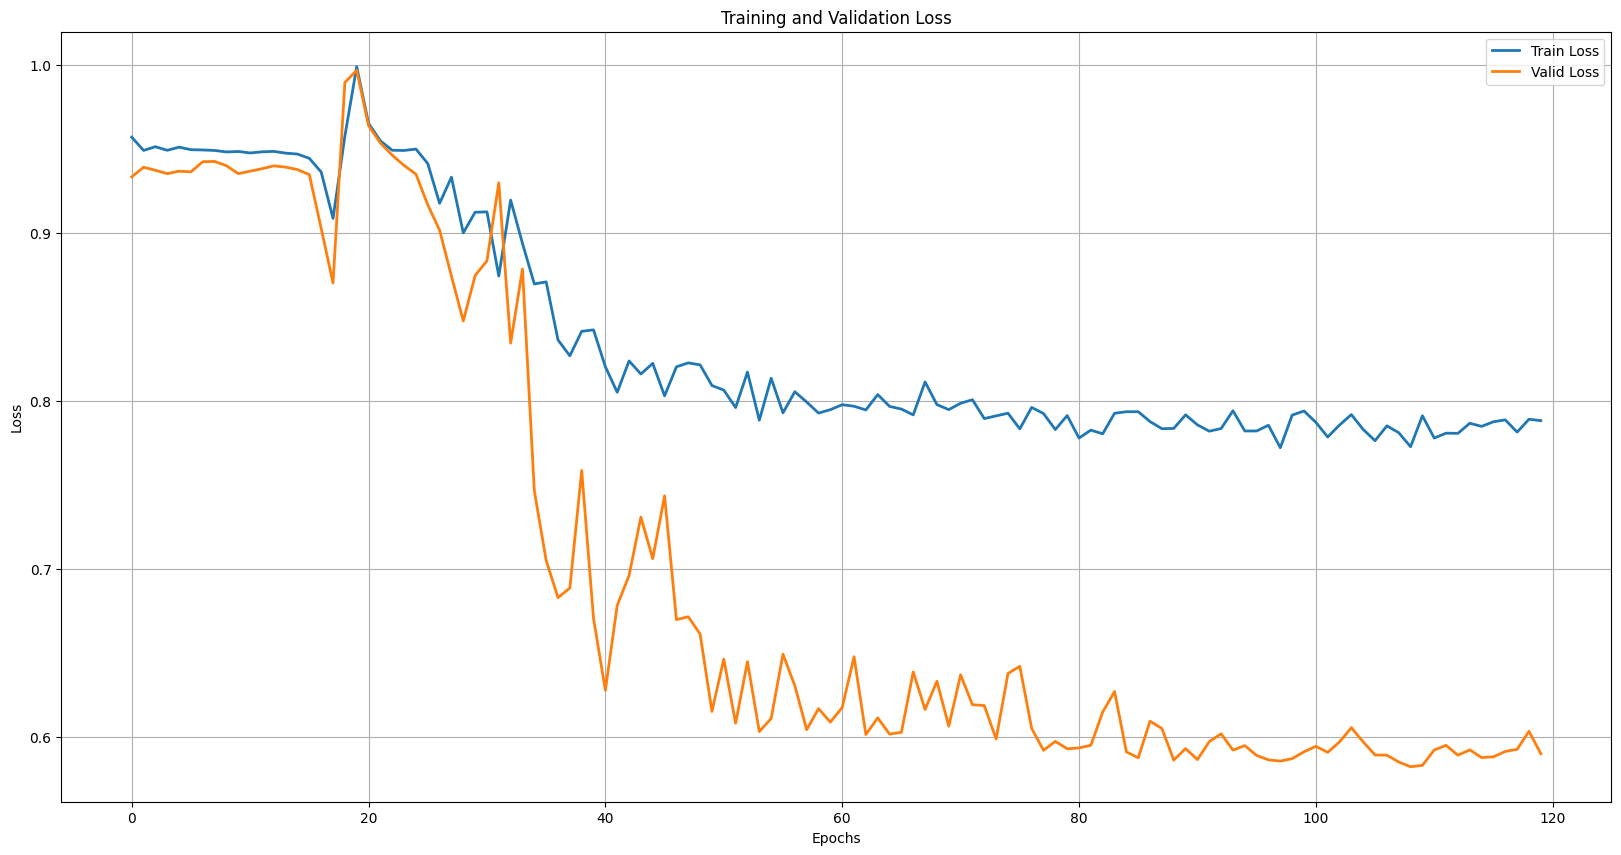

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(epochs, train_losses, label="Train Loss", linestyle="-", linewidth=2)
plt.plot(epochs, valid_losses, label="Valid Loss", linestyle="-", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
unique, counts = np.unique(y_dev_label, return_counts=True)

sorted_indices = np.argsort(-counts)
top_classes = unique[sorted_indices[:36]]
top_counts = counts[sorted_indices[:36]]

for i in range(36):
    print(f"Top {i+1}: 類別 {top_classes[i]}, 出現次數 {top_counts[i]}")

Top 1: 類別 0.5, 出現次數 124
Top 2: 類別 1.0, 出現次數 118
Top 3: 類別 0.875, 出現次數 116
Top 4: 類別 0.125, 出現次數 112
Top 5: 類別 0.6555555555555556, 出現次數 110
Top 6: 類別 0.75, 出現次數 110
Top 7: 類別 0.8, 出現次數 110
Top 8: 類別 0.6972222222222222, 出現次數 110
Top 9: 類別 0.8416666666666667, 出現次數 110
Top 10: 類別 0.45, 出現次數 108
Top 11: 類別 0.09444444444444444, 出現次數 104
Top 12: 類別 0.05277777777777778, 出現次數 102
Top 13: 類別 0.9055555555555556, 出現次數 102
Top 14: 類別 0.375, 出現次數 102
Top 15: 類別 0.2, 出現次數 100
Top 16: 類別 0.34444444444444444, 出現次數 94
Top 17: 類別 0.30277777777777776, 出現次數 92
Top 18: 類別 0.625, 出現次數 92
Top 19: 類別 0.5916666666666667, 出現次數 82
Top 20: 類別 0.25, 出現次數 80
Top 21: 類別 0.9472222222222222, 出現次數 76
Top 22: 類別 0.15833333333333333, 出現次數 72
Top 23: 類別 0.55, 出現次數 70
Top 24: 類別 0.4083333333333333, 出現次數 68
Top 25: 類別 0.5722222222222222, 出現次數 44
Top 26: 類別 0.325, 出現次數 36
Top 27: 類別 0.16666666666666666, 出現次數 36
Top 28: 類別 0.9583333333333334, 出現次數 32
Top 29: 類別 0.10277777777777777, 出現次數 30
Top 30: 類別 0.42777777777777776, 出現次數 

In [ ]:
model.eval() 
outputs = []

with torch.no_grad():  
    dataset = myDataset(x_dev_data[:10], y_dev_label[:10])
    valid_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    for batch in valid_dataloader:
        x_batch, _ = batch  
        x_batch = x_batch.to(device)  
        output = model(x_batch)     
        outputs.append(output.cpu())  

final_output = torch.cat(outputs, dim=0).numpy()
print("模型輸出：", final_output)
print("對應標籤：", y_dev_label[:10])

模型輸出： [[ 0.12542517 -0.00702825]
 [ 0.09679431 -0.00817725]
 [-0.07137382  0.0330518 ]
 [-0.07234246  0.03287911]
 [ 0.15517896 -0.02557111]
 [ 0.15717447 -0.03099509]
 [-0.0563693   0.03294155]
 [-0.00899082  0.02534669]
 [-0.12919645  0.02869449]
 [-0.21441972  0.01948779]]
對應標籤： [[ 0.83205029  0.5547002 ]
 [ 0.9486833  -0.31622777]
 [-0.51449576  0.85749293]
 [-0.70710678  0.70710678]
 [ 0.83205029  0.5547002 ]
 [ 0.9486833  -0.31622777]
 [-0.51449576  0.85749293]
 [-0.70710678  0.70710678]
 [-0.70710678  0.70710678]
 [-0.83205029  0.5547002 ]]


In [ ]:
batch_size = 32
dataset = myDataset(x_dev_data[:500], y_dev_label[:500])
valid_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=0)
dataset = myDataset(x_dev_data[500:],y_dev_label[500:])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                        num_workers=0)

In [ ]:
print(x_train_data[3])
print(max(x_train_data[3][0]),min(x_train_data[3][0]))
print(x_dev_data[3])
print(max(x_dev_data[3][0]),min(x_dev_data[3][0]))

[[-0.00869554 -0.00871348 -0.00870609 ... -0.00864232 -0.00864232
  -0.00864232]
 [-0.00869554 -0.00871348 -0.00870609 ... -0.00864232 -0.00864232
  -0.00864232]]
0.018850565 -0.037484586
[[-0.06006342 -0.06005776 -0.06006694 ... -0.06006122 -0.06006122
  -0.06006122]
 [-0.06005961 -0.06006259 -0.06006008 ... -0.06006122 -0.06006122
  -0.06006122]]
0.04342413 -0.17331737


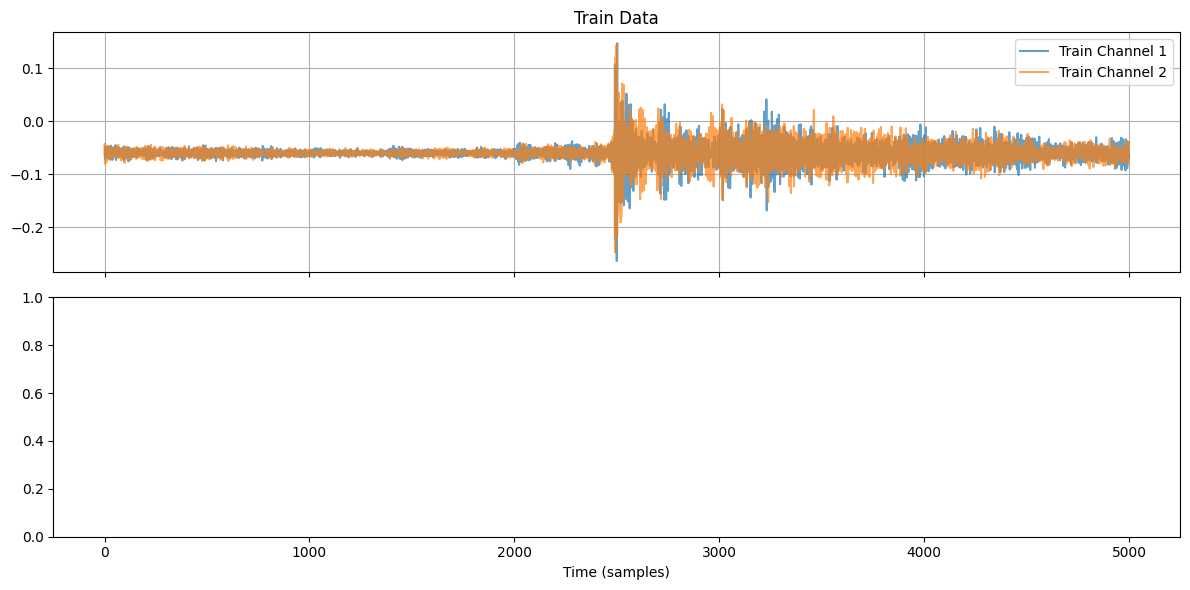

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

batch_x, batch_y = next(iter(dataloader))
x = batch_x[0].detach().cpu().numpy()
time_axis = np.arange(x.shape[1]) 

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(time_axis, x[0], label="Train Channel 1", alpha=0.7)
axes[0].plot(time_axis, x[1], label="Train Channel 2", alpha=0.7)
axes[0].set_title("Train Data")
axes[0].legend()
axes[0].grid()

plt.xlabel("Time (samples)")
plt.tight_layout()
plt.show()